# Sprawozdanie 3
## Jakub Ciągło (275986), Mateusz Ćwiek (276011)

___
# Importy

In [14]:
from scipy import stats 
import numpy as np
import pandas as pd
import math
from statsmodels.stats.contingency_tables import mcnemar
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import patsy, statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=PerfectSeparationWarning)

___ 
# Część I i II

___
## Zadanie 1 
**Test symetrii dla tabeli 2×2**

W zadaniu zdefiniowana została funkcja obliczająca p‑wartość w warunkowym teście symetrii dla tabeli 2×2 na podstawie rozkładu dwumianowego. 

In [2]:
def symmetry_test_2x2(table, alpha=None):
    n12 = table[0][1]
    n21 = table[1][0]
    n = n12 + n21

    if n == 0:
        return 1.0

    k = min(n12, n21)
    p_lower = stats.binom.cdf(k, n, 0.5)
    p_value = 2 * p_lower
    if p_value > 1:
        p_value = 1.0

    return p_value

tab = [[1, 5],
       [2,  4]]
p = symmetry_test_2x2(tab, alpha=0.05)
print(f"p-value testu symetrii = {p:.4f}")

p-value testu symetrii = 0.4531


In [3]:
tab = np.array([[1, 5],
                [2, 4]])

result_mcn = mcnemar(tab, exact=False, correction=True)
print(f"McNemar z poprawką:  stat = {result_mcn.statistic:.4f},  p-value = {result_mcn.pvalue:.4f}")

p_sym = symmetry_test_2x2(tab)
print(f"Warunkowy test symetrii: p-value = {p_sym:.4f}")

alpha = 0.05
print("\nWnioski:")
print(f"- McNemar: p = {result_mcn.pvalue:.4f} {'< α' if result_mcn.pvalue < alpha else '>= α'} →", 
      "odrzucamy H₀ o równej skuteczności leków" if result_mcn.pvalue < alpha else "brak podstaw do odrzucenia H₀")
print(f"- Symetryczny (warunkowy): p = {p_sym:.4f} {'< α' if p_sym < alpha else '>= α'} →", 
      "odrzucamy H₀" if p_sym < alpha else "brak podstaw do odrzucenia H₀")

McNemar z poprawką:  stat = 0.5714,  p-value = 0.4497
Warunkowy test symetrii: p-value = 0.4531

Wnioski:
- McNemar: p = 0.4497 >= α → brak podstaw do odrzucenia H₀
- Symetryczny (warunkowy): p = 0.4531 >= α → brak podstaw do odrzucenia H₀


Zarówno test McNemara z poprawką na ciągłość (p-value = 0,4497), jak i warunkowy test symetrii (p-value = 0,4531) nie dały podstaw do odrzucenia hipotezy zerowej przy poziomie ufności $\alpha$ = 0,05, co oznacza brak dowodów na różnicę w skuteczności obu leków.

___
## Zadanie 3
**Symulacyjne porównanie mocy testów Z i Z₀**

Dla różnych rozmiarów próby (n = 10, 30, 50, 100) zostanie przeprowadzona symulacja porównująca moc klasycznego testu Z oraz uproszczonego testu Z₀. Moc zostanie oszacowana dla 99 różnych wartości parametru $p_2$, przy stałym $p_1 = 0{,}5$, na podstawie 5000 prób losowanych z rozkładu wielomianowego. 


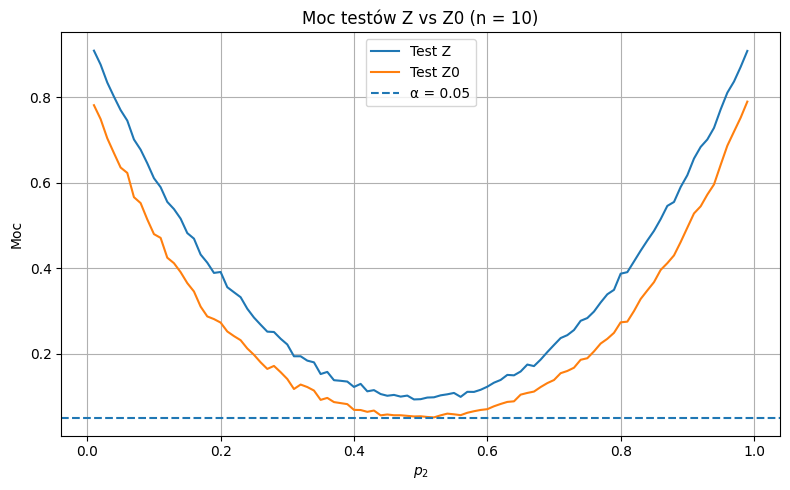

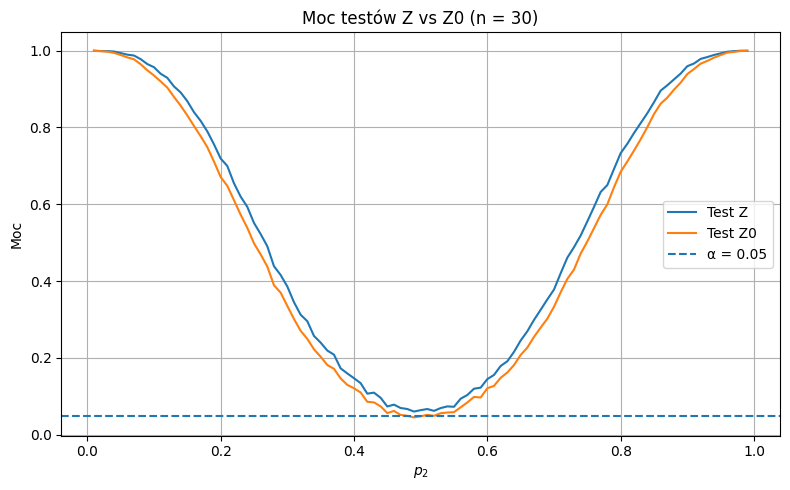

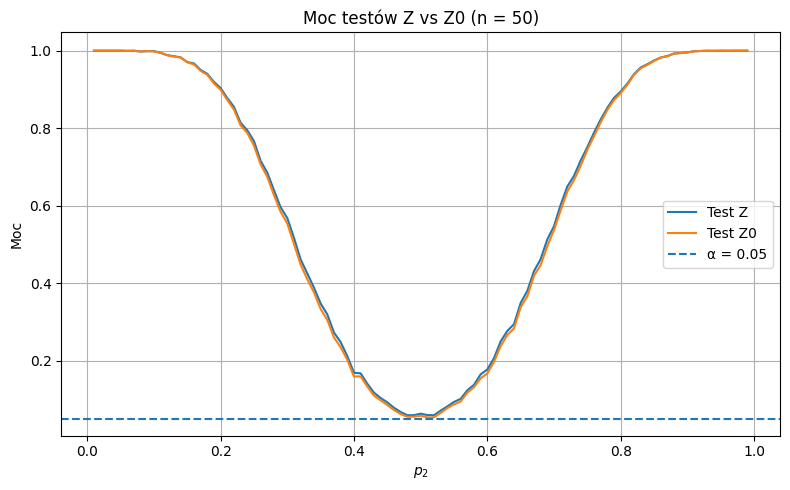

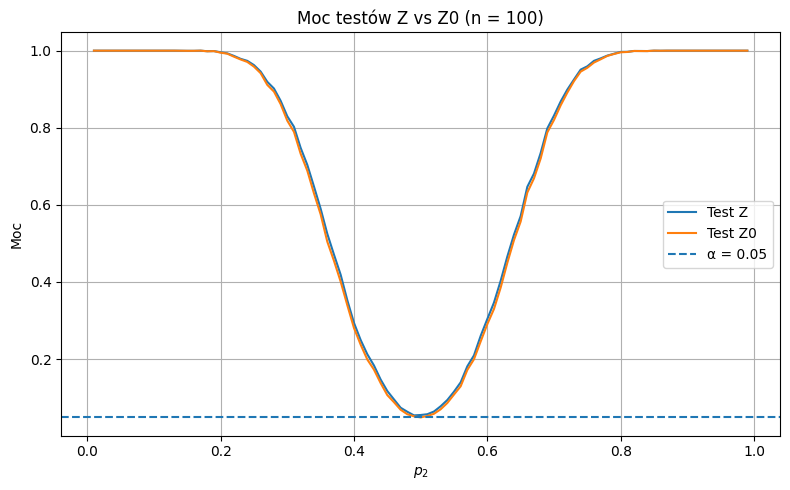

In [4]:
p1 = 0.5
p2_values = np.linspace(0.01, 0.99, 99)
n_list = [10, 30, 50, 100]
M = 5000                  
alpha = 0.05
zcrit = stats.norm.ppf(1 - alpha / 2)

rng = np.random.default_rng(42)

def z_test(counts):
    n11, n12, n21, n22 = counts.T
    n = n11 + n12 + n21 + n22

    p1_plus = (n11 + n12) / n
    p_plus1 = (n11 + n21) / n
    p11 = n11 / n
    p12 = n12 / n
    p21 = n21 / n
    p22 = n22 / n

    D = (n12 - n21) / n
    sigma_hat = (p1_plus * (1 - p1_plus) +
                 p_plus1 * (1 - p_plus1) -
                 2 * (p11 * p22 - p12 * p21)) / n
    z_stat = np.divide(D, np.sqrt(sigma_hat, where=sigma_hat > 0),
                       out=np.zeros_like(D), where=sigma_hat > 0)
    return z_stat

def z0_test(counts):
    n11, n12, n21, n22 = counts.T
    denom = np.sqrt(n12 + n21)
    z_stat = np.divide(n12 - n21, denom,
                       out=np.zeros_like(denom, dtype=float), where=denom > 0)
    return z_stat

power_Z = {n: np.zeros_like(p2_values) for n in n_list}
power_Z0 = {n: np.zeros_like(p2_values) for n in n_list}

for n in n_list:
    for idx, p2 in enumerate(p2_values):
        probs = [p1 * p2, p1 * (1 - p2), (1 - p1) * p2, (1 - p1) * (1 - p2)]
        counts = rng.multinomial(n, probs, size=M)

        power_Z[n][idx] = np.mean(np.abs(z_test(counts)) > zcrit)
        power_Z0[n][idx] = np.mean(np.abs(z0_test(counts)) > zcrit)

for n in n_list:
    plt.figure(figsize=(8, 5))
    plt.plot(p2_values, power_Z[n], label='Test Z')
    plt.plot(p2_values, power_Z0[n], label='Test Z0')
    plt.axhline(alpha, linestyle='--', label='α = 0.05')
    plt.grid(True)
    plt.xlabel('$p_2$')
    plt.ylabel('Moc')
    plt.title(f'Moc testów Z vs Z0 (n = {n})')
    plt.legend()
    plt.tight_layout()
    plt.show()


* Dla małych prób (n = 10) test $Z$ wykazuje wyraźnie większą moc niż test $Z_0$ dla większości wartości parametru $p_2$. Oznacza to, że test $Z$ ma większą zdolność do wykrycia różnicy między proporcjami przy małych licznościach.
* Wraz ze wzrostem liczebności próby (n = 30, 50, 100) różnice w mocy testów $Z$ i $Z_0$ maleją. Dla większych prób oba testy dają niemal identyczne wyniki — ich moc praktycznie się pokrywa.
* Dla dużych wartości n oba testy osiągają moc bliską 1 w przypadku istotnych różnic między $p_1$ a $p_2$, a przy $p_2 = 0,5$ (czyli zgodności z hipotezą zerową) moc zbiega do poziomu istotności $\alpha$ = 0.05 — zgodnie z oczekiwaniami.
* Test $Z$ jest bardziej czuły, ale jego przewaga nad testem $Z_0$ ma znaczenie głównie przy małych próbach. Dla większych prób wybór testu nie wpływa istotnie na wynik analizy.

___
## Zadanie 4
**Weryfikacja hipotezy symetrii poziomu zadowolenia ze szkoleń w dwóch okresach badania**

W zadaniu 4 sprawdzono, czy poziom zadowolenia ze szkoleń w dwóch okresach pierwszego badania (zmienne **CZY_ZADW** i **CZY_ZADW_2**) uległ zmianie. W tym celu zastosowano test McNemara z poprawką na ciągłość, odpowiedni dla danych sparowanych w tabeli 2×2. Test ten pozwala zweryfikować hipotezę symetrii, czyli brak istotnej różnicy między odpowiedziami w dwóch pomiarach.

In [5]:
df = pd.read_csv("ankieta.csv", sep=";", encoding="Latin2")

df['CZY_ZADW'] = df['PYT_2'].replace({
    -2: 'niezadowolony',
    -1: 'niezadowolony',
     1: 'zadowolony',
     2: 'zadowolony'
})

df['CZY_ZADW_2'] = df['PYT_3'].replace({
    -2: 'niezadowolony',
    -1: 'niezadowolony',
     1: 'zadowolony',
     2: 'zadowolony'
})

ct = pd.crosstab(df['CZY_ZADW'], df['CZY_ZADW_2'])
print("Tabela kontyngencji (przed vs po):")
print(ct, "\n")

res = mcnemar(ct, exact=False, correction=True)

print(f"McNemar (Yates): stat = {res.statistic:.4f}, p-value = {res.pvalue:.4f}")

alpha = 0.05
if res.pvalue < alpha:
    print("→ ODRZUCAMY H₀: poziom zadowolenia uległ istotnej zmianie.")
else:
    print("→ Brak podstaw do odrzucenia H₀: nie ma dowodu na zmianę poziomu zadowolenia.")

Tabela kontyngencji (przed vs po):
CZY_ZADW_2     niezadowolony  zadowolony
CZY_ZADW                                
niezadowolony             74          20
zadowolony                 8          98 

McNemar (Yates): stat = 4.3214, p-value = 0.0376
→ ODRZUCAMY H₀: poziom zadowolenia uległ istotnej zmianie.


Korzystając z uzyskanych wyników ($p-value \approx 0,038$) odrzucamy hipotezę zerową i przyjmujemy hipotezę alternatywną. Oznacza to, że poziom zadowolenia ze szkoleń wśród pracowników uległ istotnej zmianie.

___
## Zadanie 5
**Ocena zmiany opinii o podejściu firmy do wdrażania wiedzy — test symetrii odpowiedzi**

W celu oceny, czy podejście firmy do umożliwiania wdrażania wiedzy zdobytej na szkoleniach zostało odmiennie ocenione w dwóch badanych okresach, przeprowadzono testy zgodności z modelem symetrii. Wykorzystano test Bowkera oraz test informacyjny IW na podstawie pięciopunktowej skali odpowiedzi (od –2 do 2).

Test Bowkera pozwala zweryfikować, czy macierz odpowiedzi jest symetryczna względem głównej przekątnej, co oznacza brak zmiany ocen pomiędzy okresami. 

In [6]:
table = np.array([
    [10, 2, 1, 1, 0],
    [0, 15, 1, 1, 0],
    [1, 1, 32, 6, 0],
    [0, 0, 1, 96, 3],
    [1, 1, 0, 1, 26]
], dtype=int)

def bowker_test(tab: np.ndarray):
    I = tab.shape[0]
    stat = 0.0
    df = 0
    for i in range(I):
        for j in range(i + 1, I):
            nij, nji = tab[i, j], tab[j, i]
            denom = nij + nji
            if denom == 0:
                continue
            stat += (nij - nji) ** 2 / denom
            df += 1
    p_val = 1 - stats.chi2.cdf(stat, df) if df > 0 else np.nan
    return stat, df, p_val


def iw_test(tab: np.ndarray):
    I = tab.shape[0]
    n_total = tab.sum()
    stat = 0.0
    for i in range(I):
        for j in range(I):
            nij = tab[i, j]
            if nij == 0:
                continue
            p_hat = (tab[i, j] + tab[j, i]) / (2 * n_total)
            stat += 2 * nij * np.log(nij / (n_total * p_hat))
    r = I * (I - 1) // 2
    p_val = 1 - stats.chi2.cdf(stat, r)
    return stat, r, p_val


bow_stat, bow_df, bow_p = bowker_test(table)
iw_stat, iw_df, iw_p = iw_test(table)

results = pd.DataFrame({
    "Test": ["Bowkera", "IW"],
    "Statystyka": [bow_stat, iw_stat],
    "df": [bow_df, iw_df],
    "p‑value": [bow_p, iw_p]
})

results

,Test,Statystyka,df,p‑value
0,Bowkera,10.571429,9,0.306232
1,IW,13.326695,10,0.205975


Dla obu testów wartość p > α, zatem nie ma podstaw do odrzucenia hipotezy zerowej.

Formalnie oznacza to, że obserwowana tablica odpowiedzi z pierwszego i drugiego pomiaru jest zgodna z modelem symetrii.


Ponieważ nie wykryto istotnej niesymetrii, oznacza to, że brakuje dowodów statystycznych na to, by rozkład odpowiedzi w drugim badaniu różnił się od rozkładu w pierwszym.

Innymi słowy, z punktu widzenia statystyki nie możemy stwierdzić, że ocena podejścia firmy do wdrażania wiedzy uległa zmianie po wprowadzeniu działań poprawiających komfort pracy.


___
# Część III
___
## Zadanie 6

**Analiza efektów leczenia i identyfikacja paradoksu Simpsona**

Celem analizy było porównanie skuteczności dwóch metod leczenia: nowej procedury (Leczenie A) i dotychczas stosowanej (Leczenie B). Zbadano odsetek poprawy w całej grupie pacjentów, a także osobno w podgrupach pacjentów z chorobami współistniejącymi oraz pacjentów zdrowych.



In [7]:
overall = np.array([[117, 104],
                    [177,  44]])  

comorb = np.array([[17, 101],
                   [ 2,  36]])

healthy = np.array([[100, 3],
                    [175, 8]])

tables = {"Cała grupa": overall, "Z chorobami": comorb, "Bez chorób": healthy}

def improvement_rates(tab):
    rate_A = tab[0, 0] / tab[0].sum()
    rate_B = tab[1, 0] / tab[1].sum()
    return rate_A, rate_B, rate_B - rate_A

def chi2_test(tab):
    chi2, p, dof, _ = stats.chi2_contingency(tab, correction=False)
    return chi2, dof, p

prob_rows = []
chi_rows = []

for name, tab in tables.items():
    rA, rB, diff = improvement_rates(tab)
    prob_rows.append(
        {"Tabela": name,
         "P(poprawa|A)": rA,
         "P(poprawa|B)": rB,
         "Różnica B−A": diff}
    )
    
    chi, df, p = chi2_test(tab)
    chi_rows.append(
        {"Tabela": name,
         "χ²": chi,
         "df": df,
         "p‑value": round(p, 3)}
    )

df_probs = pd.DataFrame(prob_rows)
df_chi   = pd.DataFrame(chi_rows)

df_probs

,Tabela,P(poprawa|A),P(poprawa|B),Różnica B−A
0,Cała grupa,0.529412,0.800905,0.271493
1,Z chorobami,0.144068,0.052632,-0.091436
2,Bez chorób,0.970874,0.956284,-0.014590


W całej populacji metoda B (stara procedura) wydaje się skuteczniejsza (wyższe P(poprawa)). Jednak w obu podgrupach (pacjenci z chorobami współistniejącymi i bez nich) metoda A (nowa) ma wyższy odsetek poprawy.

In [8]:
df_chi

,Tabela,χ²,df,p‑value
0,Cała grupa,36.569222,1,0.000
1,Z chorobami,2.246739,1,0.134
2,Bez chorób,0.379330,1,0.538


- Cała grupa: zależność między metodą a wynikiem leczenia jest statystycznie istotna (p < 0,05).

- Podgrupy: brak istotnej różnicy skuteczności (p > 0,05) – choć wartości procentowe faworyzują A, test nie odrzuca H₀.

Występuje paradoks Simpsona. W połączonych danych (Tabela 3) metoda B przewyższa metodę A, natomiast w każdej z dwóch podgrup (Tabele 4 i 5) metoda A jest lepsza lub przynajmniej nie gorsza. To klasyczna odwracająca się zależność, spełniająca warunki paradoksu Simpsona.

___
## Zadanie 7

W modelach log-liniowych każda para nawiasów kwadratowych zawiera najwyższy uwzględniany iloczyn (interakcję).  
Model jest hierarchiczny: jeśli zawiera interakcję (np. [13]), to automatycznie obejmuje wszystkie niższe rzędy występujące w tym iloczynie (tu: efekty główne 1 i 3).  
Gdy w nawiasie jest kilka cyfr bez przerwy (np. [13]), oznacza to interakcję tych zmiennych;  
gdy cyfry są rozdzielone spacją (np. [1 3]), to po prostu dwa oddzielne efekty główne.

| symbol | zmienna   | kategorie |
|--------|-----------|-----------|
| 1      | CZY_KIER – stanowisko kierownicze? | Tak / Nie |
| 2      | PYT_2 – opinia o dostosowaniu szkoleń (-2,-1,1,2) | skala porządkowa |
| 3      | STAŻ – długość pracy w firmie | 1 < 1r. · 2 (1–3 l.) · 3 (>3 l.) |

### Interpretacje modeli

| model     | ujęte interakcje                  | założenia (nieobecne interakcje → niezależności) | słowny opis |
|-----------|-----------------------------------|--------------------------------------------------|-------------|
| [1 3]     | tylko efekty główne 1 i 3         | brak związku 1 ↔ 3, 2 nie wchodzi do modelu ⇒ 2 nie koreluje z żadną zmienną | Ocena szkoleń (PYT_2) jest niezależna zarówno od pełnienia funkcji kierowniczej, jak i od stażu; ponadto stanowisko kierownicze nie wiąże się ze stażem. |
| [13]      | interakcja 1×3 (oraz ich efekty główne) | PYT_2 (2) niezależna od 1 i 3 | Staż i status kierowniczy są powiązane; opinia o szkoleniach nie zależy od żadnej z tych dwóch cech. |
| [1 2 3]   | wyłącznie efekty główne 1, 2, 3   | żadnych interakcji ⇒ pełna niezależność 1, 2, 3 | Trzy zmienne są wzajemnie niezależne: opinia o szkoleniach nie zależy ani od stażu, ani od stanowiska, a staż nie jest związany z pełnieniem funkcji kierowniczej. |
| [12 3]    | interakcja 1×2; samodzielny efekt 3 | brak interakcji z 3 ⇒ 3 ⟂ {1,2} | Opinia o szkoleniach zależy od statusu kierowniczego; staż jest całkowicie niezależny zarówno od stanowiska, jak i od odpowiedzi w PYT_2. |
| [12 13]   | interakcje 1×2 i 1×3              | brak 2×3 ⇒ 2 ⟂ 3 \| 1 | Status kierowniczy wpływa zarówno na opinię o szkoleniach, jak i na staż. Po uwzględnieniu stanowiska, opinia z PYT_2 nie zależy już od stażu. |
| [1 23]    | interakcja 2×3; samodzielny efekt 1 | brak 1×2, 1×3 ⇒ 1 ⟂ {2,3} | Opinia o szkoleniach różni się w zależności od stażu, ale jest niezależna od statusu kierowniczego; sam status kierowniczy nie jest też związany ze stażem. |

 
Brak interakcji między zmiennymi oznacza, że ich rozkłady są (warunkowo) niezależne w danym modelu.

Obecność interakcji pozwala na dowolną zależność między odpowiadającymi zmiennymi (model nie narzuca ograniczeń na ich tablicę kontyngencji).

W rezultacie każdy model można testować (porównując z modelami nadrzędnymi) i sprawdzać, które założenia niezależności są zgodne z rzeczywistymi danymi ankiety.


___
## Zadanie 8

In [15]:
df = pd.read_csv('ankieta.csv', encoding='Latin2', sep=';')

for col in ['CZY_KIER', 'PYT_2', 'STAŻ']:
    df[col] = df[col].astype('category')

tab1 = (
    df.groupby(['CZY_KIER', 'PYT_2', 'STAŻ'])
      .size()
      .reset_index(name='Freq')
)

y, X = patsy.dmatrices('Freq ~ C(CZY_KIER)*C(PYT_2)*C(STAŻ)',
                       tab1, return_type='dataframe')
model_123 = sm.GLM(y, X, family=sm.families.Poisson()).fit()
tab1['fitted_123'] = model_123.fittedvalues

y2, X2 = patsy.dmatrices(
    'Freq ~ C(CZY_KIER)*C(PYT_2) + C(PYT_2)*C(STAŻ)',
    tab1, return_type='dataframe')
model_1223 = sm.GLM(y2, X2, family=sm.families.Poisson()).fit()
tab1['fitted_1223'] = model_1223.fittedvalues


def p_event(table, fitcol, **conditions):
    """Warunki podaj jako nazwa_zmiennej='wartość'."""
    mask = pd.Series(True, index=table.index)
    for k, v in conditions.items():
        mask &= table[k] == v
    return table.loc[mask, fitcol].sum() / table[fitcol].sum()

conds_a = {'CZY_KIER': 'Tak', 'PYT_2': 2}        # kierownik & „2”
conds_b = {'STAŻ': 1, 'CZY_KIER': 'Tak'}         # staż 1 & kierownik
conds_c = {'STAŻ': 3, 'CZY_KIER': 'Nie'}         # staż 3 & nie-kier.


out = []
for lab, conds in zip(['a', 'b', 'c'], [conds_a, conds_b, conds_c]):
    out.append({
        'Zdarzenie': lab,
        'p-dane'           : p_event(tab1, 'Freq',          **conds),
        'p-model [123]'    : p_event(tab1, 'fitted_123',    **conds),
        'p-model [12 23]'  : p_event(tab1, 'fitted_1223',   **conds)
    })

results = pd.DataFrame(out)
results


,Zdarzenie,p-dane,p-model [123],p-model [12 23]
0,a,0.065,0.065,0.065000
1,b,0.005,0.005,0.026264
2,c,0.050,0.050,0.073919


Prawdopodobieństwa empiryczne (p-dane) i z modelu [123] są identyczne (model idealnie odtwarza tablicę). W modelu [12 23] brak interakcji CZY_KIER x STAŻ powoduje, że:

- zdarzenie b (staż < 1 rok ∧ kierownik) oraz c (staż > 3 lata ∧ nie-kierownik) są przewidywane częściej niż rzeczywiście występują,
- zdarzenie a (kierownik zdecydowanie zadowolony) pozostaje bez zmian – jego prawdopodobieństwo zależy tylko od interakcji 1x2, która w modelu [12 23] jest zachowana.

W skrócie: uproszczony model [12 23] przeszacowuje rzadkie kombinacje stażu i stanowiska, bo nie pozwala na bezpośredni związek między tymi dwiema zmiennymi.

___
## Zadanie 9
statsmodels.stats.anova_lm() nie obsługuje obiektów GLM (brak atrybutu .ssr).
Zamiast tego używamy wbudowanego testu ilorazu wiarygodności compare_lr_test, co dokładnie odpowiada różnicy deviancji.

In [20]:
import pandas as pd, patsy, statsmodels.api as sm
from itertools import combinations
from scipy.stats import chi2

α = 0.05          # poziom istotności

# ----------------------------------------------------
# 1. Wczytanie danych i tablica liczności -------------
# ----------------------------------------------------
df = pd.read_csv('ankieta.csv', sep=';', encoding='Latin2')
for col in ['CZY_KIER', 'PYT_2', 'STAŻ']:
    df[col] = df[col].astype('category')

tab = (df.groupby(['CZY_KIER', 'PYT_2', 'STAŻ'], observed=True)
         .size().reset_index(name='Freq'))

# ----------------------------------------------------
# 2. Funkcja pomocnicza -------------------------------
# ----------------------------------------------------
def fit(formula):
    y, X = patsy.dmatrices(formula, tab, return_type='dataframe')
    return sm.GLM(y, X, family=sm.families.Poisson()).fit()

def lr_test(base, sup, alpha=0.05):
    """base ⊂ sup  →  zwraca ΔD, Δdf, p-value, decyzję"""
    ΔD   = base.deviance - sup.deviance           # różnica deviancji
    Δdf  = base.df_resid - sup.df_resid           # różnica df
    p    = chi2.sf(ΔD, Δdf)                       # chi-kwadrat
    dec  = "odrzucamy H₀" if p < alpha else "nie odrzucamy"
    return ΔD, int(Δdf), p, dec

# ----------------------------------------------------
# 3. Hipoteza (a)  CZY_KIER ⟂ PYT_2 ⟂ STAŻ ----------
#    M0 = [1 2 3]  (pełna niezależność)
#    rozważamy ≥3 nadmodele (przykład ze slajdu)
# ----------------------------------------------------
M0_a = fit('Freq ~ C(CZY_KIER) + C(PYT_2) + C(STAŻ)')
M1_a = fit('Freq ~ C(CZY_KIER)*C(PYT_2) + C(STAŻ)')          # [12]3
M2_a = fit('Freq ~ C(CZY_KIER) + C(PYT_2)*C(STAŻ)')          # 1[23]
M3_a = fit('Freq ~ C(CZY_KIER)*C(STAŻ) + C(PYT_2)')          # [13]2

# ----------------------------------------------------
# 4. Hipoteza (b)  PYT_2 ⟂ (CZY_KIER, STAŻ)
#    M0 = [13]       (PYT_2 niezależna od pary)
# ----------------------------------------------------
M0_b = fit('Freq ~ C(CZY_KIER)*C(STAŻ)')                     # [13]
M1_b = fit('Freq ~ C(CZY_KIER)*C(PYT_2) + C(CZY_KIER)*C(STAŻ)')  # [12][13]
M2_b = fit('Freq ~ C(CZY_KIER)*C(STAŻ) + C(PYT_2)*C(STAŻ)')      # [13][23]
M3_b = fit('Freq ~ C(CZY_KIER)*C(PYT_2)*C(STAŻ)')                # [123]

# ----------------------------------------------------
# 5. Hipoteza (c)  PYT_2 ⟂ CZY_KIER | STAŻ
#    M0 = [1 23]    (brak 1×2 po uwzględnieniu 3)
#    tylko 2 nadmodele (patrz notatka)
# ----------------------------------------------------
M0_c = fit('Freq ~ C(CZY_KIER) + C(PYT_2)*C(STAŻ)')          # [1 23]
M1_c = fit('Freq ~ C(CZY_KIER)*C(PYT_2) + C(PYT_2)*C(STAŻ)') # [12 23]
M2_c = fit('Freq ~ C(CZY_KIER)*C(PYT_2)*C(STAŻ)')            # [123]

# ----------------------------------------------------
# 6. Zbiorcze podsumowanie ----------------------------
# ----------------------------------------------------
tests = [
    ("a", M0_a, [("M1 [12]3", M1_a), ("M2 1[23]", M2_a), ("M3 [13]2", M3_a)]),
    ("b", M0_b, [("M1 [12][13]", M1_b), ("M2 [13][23]", M2_b), ("M3 [123]", M3_b)]),
    ("c", M0_c, [("M1 [12 23]",  M1_c), ("M2 [123]",    M2_c)]),
]

rows = []
for label, base, supers in tests:
    for name, sup in supers:
        ΔD, Δdf, p, dec = lr_test(base, sup)      # ← używamy własnej funkcji
        rows.append([label, name, round(ΔD,2), Δdf, round(p,4), dec])

out = (pd.DataFrame(rows, columns=["Hipoteza", "Nadmodel", "Δdeviance", "Δdf", "p-value", "Wniosek"])
         .assign(**{"p-value": lambda d: d["p-value"].round(4),
                    "Δdeviance": lambda d: d["Δdeviance"].round(2)}))

out


,Hipoteza,Nadmodel,Δdeviance,Δdf,p-value,Wniosek
0,a,M1 [12]3,0.17,2,0.9205,nie odrzucamy
1,a,M2 1[23],3.55,3,0.3138,nie odrzucamy
2,a,M3 [13]2,8.87,2,0.0118,odrzucamy H₀
3,b,M1 [12][13],54.12,5,0.0000,odrzucamy H₀
4,b,M2 [13][23],58.43,6,0.0000,odrzucamy H₀
5,b,M3 [123],58.60,9,0.0000,odrzucamy H₀
6,c,M1 [12 23],0.17,2,0.9169,nie odrzucamy
7,c,M2 [123],9.81,5,0.0808,nie odrzucamy
